# InfiniteRep Quick Start Notebook

Demo 1: Querying videos based on metadata  
Demo 2: Visualizing labels for a specific video

In [1]:
import os
import cv2
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

## Demo 1: Querying videos based on metadata
We'll first show how you can find specific videos in the dataset based on the provided metadata. For this example, we'll focus on three metadata labels: `percent_in_fov`, `percent_occlusion` and `camera_height`.

The `percent_in_fov` value is provided for each instance annotation. It represents the percentage of  vertices from the underlying mesh that are within the camera's field-of-view, regardless of occlusion status. Low values indicate the avatar is out-of-frame, which is often the case during floor exercises. 

The `percent_occlusion` value is also provided with each annotation and quantifies environmental occlusion. It represents the percentage of the instance that is not visible due to miscellaneous objects in the foreground. High values indicate that furniture or other environmental objects are obstructing the camera's full view of the avatar.

The `camera_height` value is provided for each video. It represents the height of the camera relative to the floor plane, in meters.

In addition to to these examples, other provided metadata like body shape and camera pitch can also be used for querying and/or filtering the dataset.

In [2]:
# specify location of the unzipped exercise folder
exercise_folder = "/path/to/data/InfinityAI_InfiniteRep_legraise_v1.0/data/"

In [3]:
# iterate over annotation jsons for each video and extract labels
json_paths = sorted(glob.glob(os.path.join(exercise_folder, "*.json")))
metadata = []
for json_path in json_paths:
    coco = COCO(json_path)
    percent_in_fov = []
    percent_occlusion = []
    for ann in coco.anns.values():
        if coco.cats[ann["category_id"]]["name"] != "person":
            # skip any non-person annotations (e.g. for dumbbells)
            continue
        percent_in_fov.append(ann["percent_in_fov"])
        percent_occlusion.append(ann["percent_occlusion"])
    avg_percent_in_fov = np.mean(percent_in_fov)  # average across frames
    avg_percent_occlusion = np.mean(percent_occlusion)  # average across frames
    metadata.append({
        "video_number": coco.dataset["info"]["video_number"],
        "avg_percent_in_fov": avg_percent_in_fov,
        "avg_percent_occlusion": avg_percent_occlusion,
        "camera_height": coco.dataset["info"]["camera_height"],
    })
metadata_df = pd.DataFrame(metadata)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
load

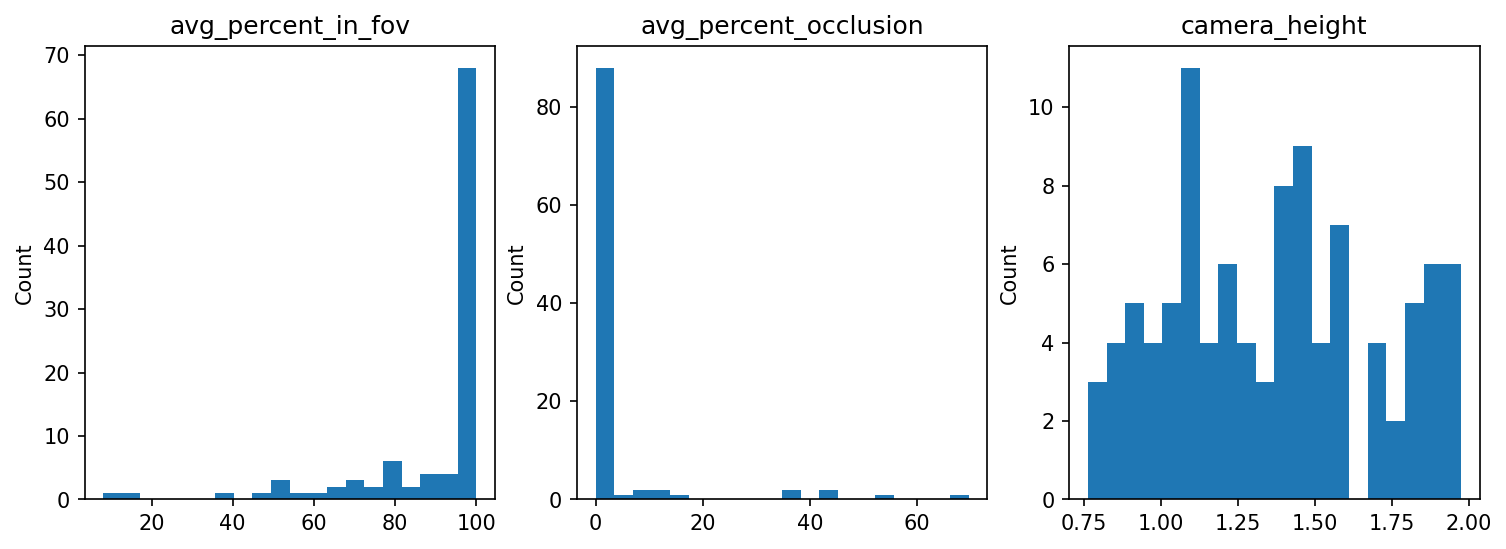

In [4]:
num_bins = 20
cols_to_plot = ["avg_percent_in_fov", "avg_percent_occlusion", "camera_height"]
fig, ax = plt.subplots(1,len(cols_to_plot),figsize=(12,4), dpi=150)
for i, col_to_plot in enumerate(cols_to_plot):   
    ax[i].hist(metadata_df[col_to_plot], bins=num_bins)
    ax[i].set_title(col_to_plot)
    ax[i].set_ylabel('Count')
plt.show()

We can see that in the majority of videos, the avatar is fully within the camera's field-of-videw (`avg_percent_in_fov = 100`), and that the camera has an unobstructed view of the avatar (`avg_percent_occlusion = 0`). However, there is a long tail of examples where this is not the case. Let's visualize some of those examples below.

In [5]:
def plot_examples(plot_df: pd.DataFrame, num_to_plot: int, title: str):
    """Displays first frame of leading N videos in dataframe."""
    fig,ax = plt.subplots(1,num_to_plot,figsize=(4*num_to_plot,4))
    for i, (_, video_data) in enumerate(plot_df[:num_to_plot].iterrows()):
        video_path = os.path.join(exercise_folder, f"{int(video_data['video_number']):06d}.mp4")
        vidcap = cv2.VideoCapture(video_path)
        success, img = vidcap.read()
        ax[i].imshow(img[:,:,::-1])
        ax[i].set_title(f"Video number: {int(video_data['video_number'])}")
        ax[i].axis("off")
    fig.suptitle(title)
    plt.show()

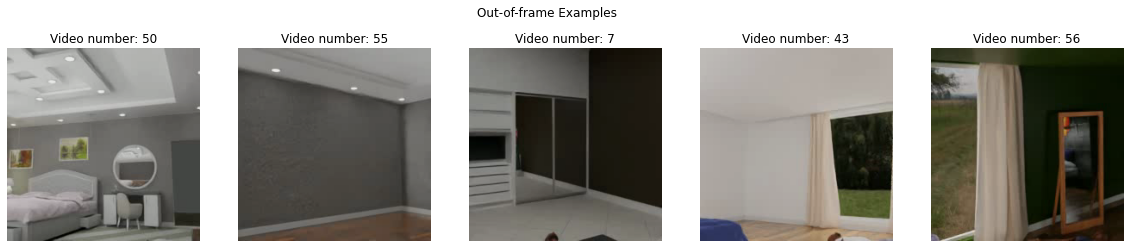

In [6]:
examples_out_of_frame = metadata_df.sort_values(by="avg_percent_in_fov", ascending=True)
plot_examples(examples_out_of_frame, num_to_plot=5, title="Out-of-frame Examples")

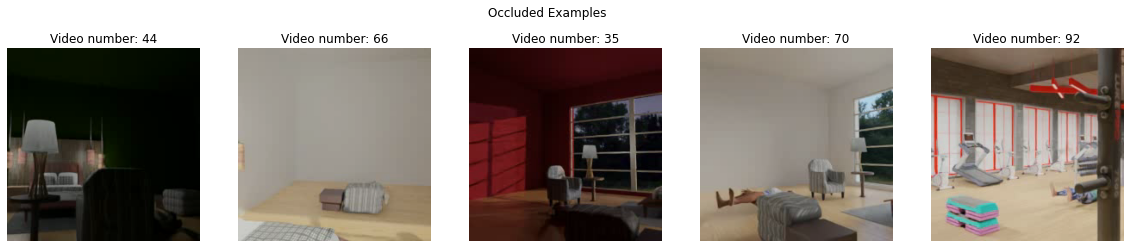

In [7]:
examples_with_occlusion = metadata_df.sort_values(by="avg_percent_occlusion", ascending=False)
plot_examples(examples_with_occlusion, num_to_plot=5, title="Occluded Examples")

We can also visualize examples where the camera is low to the ground versus higher up.

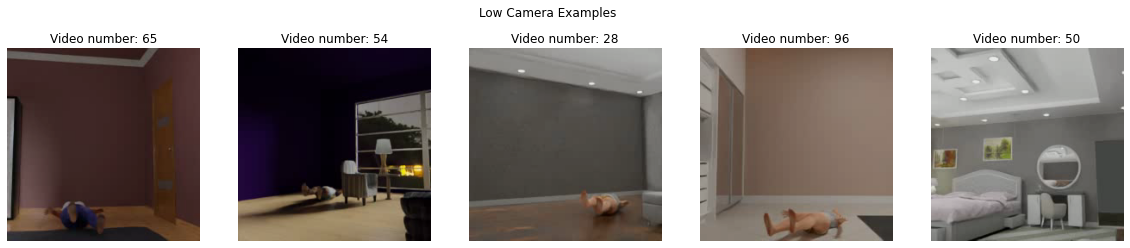

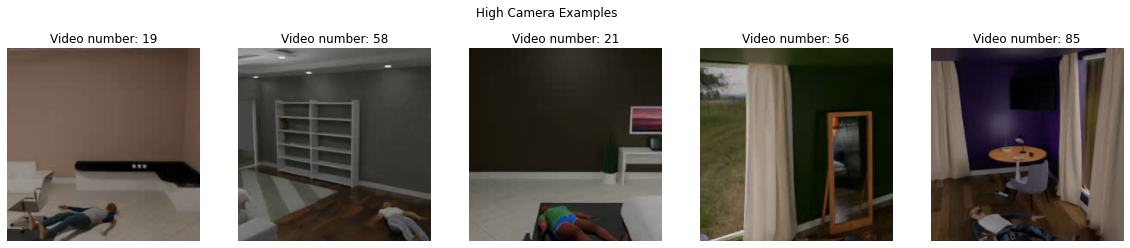

In [8]:
examples_low_cam = metadata_df.sort_values(by="camera_height", ascending=True)
examples_high_cam = metadata_df.sort_values(by="camera_height", ascending=False)

plot_examples(examples_low_cam, num_to_plot=5, title="Low Camera Examples")
plot_examples(examples_high_cam, num_to_plot=5, title="High Camera Examples")

## Demo 2: Visualizing labels for a specific video

In this next demo, we'll visualize a few of the different labels provided in InfiniteRep that can be used for training. You only need to specify the video number to use.

In [9]:
video_number = 0

video_path = os.path.join(exercise_folder, f"{video_number:06d}.mp4")
json_path = os.path.join(exercise_folder, f"{video_number:06d}.json")

We first read in the frame-level annotations and video frames, and store them in memory as a single array.

In [10]:
coco = COCO(json_path)
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
imgs = []
while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break
    imgs.append(img)
imgs = np.array(imgs)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


With the annotations loaded in, we can visualize the repetition count over time. The repetition count is provided as a continuous, frame-level value (`rep_count`), so you know exactly how many reps have been performed by a given frame.

While the repetition count monotonically increases, it is not a strictly linear function. This is because the label is adjusted to account for dynamic rep speed throughout a video.

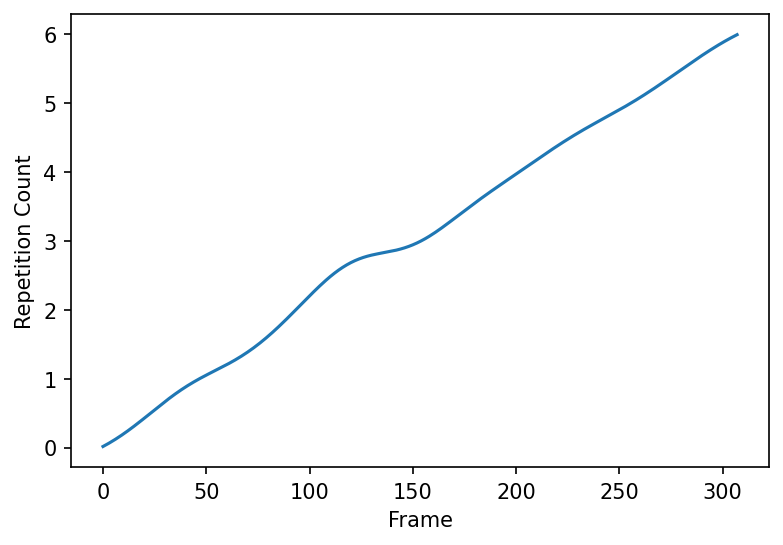

In [11]:
rep_counts = [img_data["rep_count"] for img_data in coco.imgs.values()]
fig,ax = plt.subplots(dpi=150)
ax.plot(rep_counts)
ax.set_xlabel("Frame")
ax.set_ylabel("Repetition Count")
plt.show()

We next overlay a few of the different frame-level labels onto the original RGB video. You just need to specify the `output_path` where the new mp4 files should go.

In [12]:
output_path = "./output/"
os.makedirs(output_path, exist_ok=True)

We first visualize the bounding boxes. Boxes will be overlaid for any annotation, including `person` and `dumbbell` categories.

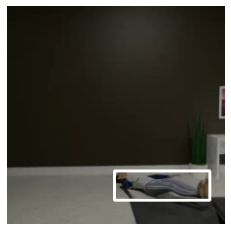

In [13]:
bb_path = os.path.join(output_path, "bbox.mp4")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
image_dims = (224,224)
out = cv2.VideoWriter(bb_path, fourcc, fps, image_dims)

for img, img_data in zip(imgs, coco.imgs.values()):
    canvas = img.copy()
    img_id = img_data["id"]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        x,y,w,h = tuple(np.array(ann["bbox"]).astype(int))
        cv2.rectangle(canvas, (x,y), (x+w, y+h), color=(255,255,255), thickness=2)   
    out.write(canvas)
out.release()

plt.imshow(canvas[:,:,::-1])
plt.axis("off")
plt.show()

We next visualize the individual 2D keypoints that are provided. Here, we use the values provided in `armature_keypoints`, which includes multiple keypoints for hand digits and multiple keypoints along the spine. Keypoint values are also provided for the standard COCO format in the `keypoints` field.

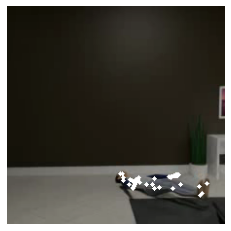

In [14]:
kp_path = os.path.join(output_path, "keypoints.mp4")
out = cv2.VideoWriter(kp_path, fourcc, fps, image_dims)

for img, img_data in zip(imgs, coco.imgs.values()):
    canvas = img.copy()
    img_id = img_data["id"]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        # skip non-person instances
        if "armature_keypoints" not in ann:
            continue
        keypoints = ann["armature_keypoints"]
        for keypoint_name, keypoint_info in keypoints.items():
            x, y = keypoint_info["x"], keypoint_info["y"]
            cv2.circle(canvas, (x, y), radius=2, color=(255,255,255), thickness=-1)
    out.write(canvas)
out.release()

plt.imshow(canvas[:,:,::-1])
plt.axis("off")
plt.show()

Finally, we visualize a skeleton of the connected keypoints.

In [15]:
kp_connections = json.load(open('armature_connections.json','r'))

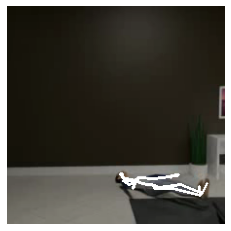

In [16]:
skel_path = os.path.join(output_path, "skeleton.mp4")
out = cv2.VideoWriter(skel_path, fourcc, fps, image_dims)

for img, img_data in zip(imgs, coco.imgs.values()):
    canvas = img.copy()
    img_id = img_data["id"]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        # skip non-person instances
        if "armature_keypoints" not in ann:
            continue
        keypoints = ann["armature_keypoints"]
        for parent, child in kp_connections:
            x0 = keypoints[parent]["x"]
            y0 = keypoints[parent]["y"]
            x1 = keypoints[child]["x"]
            y1 = keypoints[child]["y"]
            cv2.line(canvas, (x0, y0), (x1,y1), color=(255,255,255), thickness=2)
    out.write(canvas)
out.release()

plt.imshow(canvas[:,:,::-1])
plt.axis("off")
plt.show()